# WCWH Community Rollout Preparation - BEVO Beacon Design
For the upcoming rollout, we need to ensure proper aspects of the beacon are working correctly.

In [3]:
import warnings
warnings.filterwarnings('ignore')

# Internal Temperature
The purpose of this notebook is to analyze the data from a few beacons to see how the temperature readings change depending on various design considerations.

In [4]:
import os
import sys
sys.path.append('../')

import pandas as pd
import numpy as np

from datetime import datetime, timedelta

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates

import statsmodels.api as sm

## Design Considerations
The design considerations are as follows and analyzed separately:
1. **As-Is**: The do-nothing approach that might be fine based on the temperatures since not much analysis has been done with the temperature up to this point
2. **Double Fans**: Adding an extra fan might increase the air flow and reduce the amount of hot air trapped in the beacon
3. **Heat Sinks**: Adding heat sinks on the processor might be enough to dissipate the heat effectively
4. **Fans and Heat Sinks**: Of course the final, and most comprehensive idea would be to combine ideas 2 and 3.

### Analysis Class
The class below provides the framework to do the majority of the analysis.

In [5]:
class Internal_Temperature_Analysis:
    
    def __init__(self,beacon_list,ref_beacon,exp_start_datetime=datetime(2021,1,1,0,0),exp_end_datetime=datetime(2022,1,1,0,0),var="temperature_c"):
        # getting beacon data
        self.test_beacons = beacon_list
        self.ref_beacons = ref_beacon
        self.all_beacons = beacon_list + ref_beacon
        beacon = pd.read_csv("../data/processed/beacon-wcwh_0.csv",index_col=0,parse_dates=True,infer_datetime_format=True)
        self.data = beacon[beacon["beacon"].isin(beacon_list)] # experiment data
        self.ref = beacon[beacon["beacon"].isin(ref_beacon)] # reference beacon
        self.ref = self.ref.groupby(self.ref.index).mean() # averaging the ref beacon(s) data
        
        # other important paramters
        self.starting = exp_start_datetime
        self.ending = exp_end_datetime
        self.var = var
    
    def compare_timeseries(self):
        """
        Compares the time series measurements of the list of beacons
        """
        fig, ax = plt.subplots(figsize=(12,6))
        for bb in self.test_beacons:
            data_by_bb = self.data[self.data["beacon"] == bb]
            ax.plot(data_by_bb.index,data_by_bb[self.var],label=bb,zorder=bb) # test lines
        
        ax.plot(self.ref.index,self.ref[self.var],linewidth=2,color="black",label="Reference",zorder=0) # reference line
            
        ax.set_xlim([self.starting,self.ending])
        ax.legend()
        plt.show()
        plt.close()
        
    def get_delta(self):
        """
        Gets the mean and median temperature differences
        """
        delta_dict = {"beacon":[],"mean":[],"median":[]}
        for bb in self.test_beacons:
            data_by_bb = self.data[self.data["beacon"] == bb]
            avg = np.nanmean(data_by_bb[self.var]) - np.nanmean(self.ref[self.var])
            med = np.nanmedian(data_by_bb[self.var]) - np.nanmedian(self.ref[self.var])
            for key, val in zip(delta_dict.keys(),[bb,avg,med]):
                delta_dict[key] = val
                
        return delta_dict

### As-Is
Here is the analysis from the first analysis.

In [43]:
exp1 = Internal_Temperature_Analysis(beacon_list=[7,24])
exp1.compare_timeseries()

TypeError: __init__() missing 1 required positional argument: 'ref_beacon'

### Double Fans
Adding an extra fan should provide more ventilation and therefore cooler temperatures inside the RPi. 

In [6]:
exp2 = Internal_Temperature_Analysis([7,20],[8],datetime(2021,1,21,0,0),datetime(2021,1,23,0,0))

In [9]:
exp2.data

,tvoc,lux,no2,co,co2,pm1_number,pm2p5_number,pm10_number,pm1_mass,pm2p5_mass,pm10_mass,temperature_c,rh,beacon,beiwe,fitbit,redcap
timestamp,,,,,,,,,,,,,,,,,
2021-01-05 15:35:00,7.933333,64.730560,96.866667,12.037067,914.091158,49.799443,55.917377,56.776913,7.138886,13.050696,17.359840,26.50,40.00,7,a8,27,8
2021-01-05 15:40:00,9.750000,60.898080,85.650000,9.778550,913.557090,46.802050,53.496245,54.439240,6.885129,13.339523,18.070584,26.50,39.75,7,a8,27,8
2021-01-05 15:45:00,6.760000,45.229248,76.240000,7.606840,903.426792,40.771717,45.714583,46.408854,5.832444,10.609773,14.090142,26.72,39.50,7,a8,27,8
2021-01-05 15:50:00,4.320000,42.856320,70.280000,5.762000,901.058237,44.243178,48.869592,49.517440,6.191706,10.674465,13.919335,27.00,39.46,7,a8,27,8
2021-01-05 15:55:00,9.240000,32.969664,66.480000,4.427560,893.261943,40.433315,44.246354,44.779013,5.581228,9.283231,11.949343,27.00,39.04,7,a8,27,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-01-20 09:20:00,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,20,a21,40,21
2021-01-20 09:25:00,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,20,a21,40,21
2021-01-20 09:30:00,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,20,a21,40,21


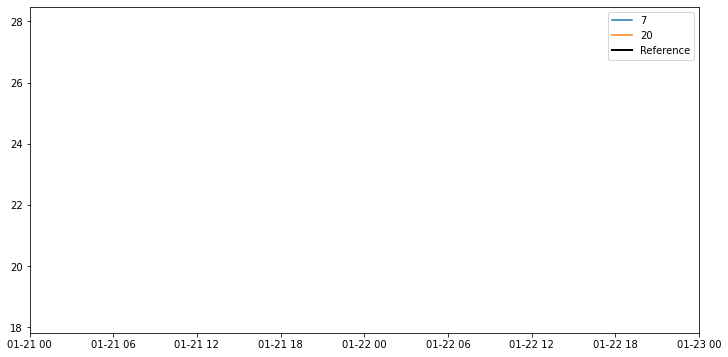

In [8]:
exp2.compare_timeseries()

In [7]:
d = exp2.get_delta()
d

{'beacon': 20, 'mean': -2.675643154341344, 'median': -2.5}